In [1]:
from learning.miniDP.EnumDef import NetType
from learning.miniDP.ImageDataReader import ImageDataReader

dataReader = ImageDataReader("../data/ch18.train_shape.npz", "../data/ch18.test_shape.npz")
dataReader.NormalizeX()
dataReader.NormalizeY(netType=NetType.MultipleClassifier)
dataReader.Shuffle()
dataReader.generateValidationSet(0.1)
print(dataReader.XTrain.shape)
print(dataReader.XTest.shape)
print(dataReader.XDev.shape)

(4500, 1, 28, 28)
(1000, 1, 28, 28)
(500, 1, 28, 28)


| ID  | 类型  | 参数             | 输入尺寸     | 输出尺寸     |
|-----|-----|----------------|----------|----------|
| 1   | 卷积  | 8x3x3, S=1,P=1 | 1x28x28  | 8x28x28  |
| 2   | 激活  | Relu           | 8x28x28  | 8x28x28  |
| 3   | 池化  | 2x2, S=2, Max  | 8x28x28  | 8x14x14  |
| 4   | 卷积  | 16x3x3, S=1    | 8x14x14  | 16x12x12 |
| 5   | 激活  | Relu           | 16x12x12 | 16x12x12 |
| 6   | 池化  | 2x2, S=2, Max  | 16x6x6   | 16x6x6   |
| 7   | 全连接 | 32             | 576      | 32       |
| 8   | 归一化 || 32             | 32       |
| 9   | 激活  | Relu           | 32       | 32       |
| 10  | 全连接 | 5              | 32       | 5        |
| 11  | 分类  | Softmax        | 5        | 5        |

epoch 0--step 19: loss=0.502756, acc=19.400002%
epoch 0--step 39: loss=0.500586, acc=19.799999%
epoch 0--step 59: loss=0.499271, acc=20.800001%
epoch 0: train_loss: 0.500871, test_loss: 0.498654, train_acc=20.000000%, test_acc=40.299999%
epoch 1--step 19: loss=0.497794, acc=31.400002%
epoch 1--step 39: loss=0.496655, acc=35.200001%
epoch 1--step 59: loss=0.494923, acc=36.599998%
epoch 1: train_loss: 0.496457, test_loss: 0.492986, train_acc=34.400001%, test_acc=40.599998%
epoch 2--step 19: loss=0.490973, acc=38.000000%
epoch 2--step 39: loss=0.487499, acc=37.599998%
epoch 2--step 59: loss=0.483638, acc=41.200001%
epoch 2: train_loss: 0.487370, test_loss: 0.479245, train_acc=38.933334%, test_acc=41.500000%
epoch 3--step 19: loss=0.477049, acc=41.400002%
epoch 3--step 39: loss=0.471493, acc=38.200001%
epoch 3--step 59: loss=0.465524, acc=38.800003%
epoch 3: train_loss: 0.471356, test_loss: 0.459115, train_acc=39.466667%, test_acc=41.600002%
epoch 4--step 19: loss=0.455300, acc=38.800003%


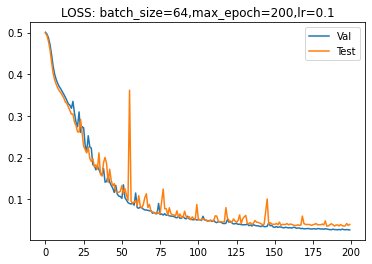

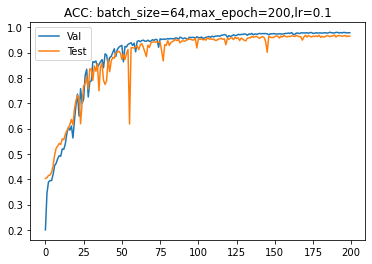

In [8]:
from torch.nn import Sequential
from torch import nn, optim
from learning.pytorchExt import PytorchExt


class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.cnn = Sequential(
            nn.Conv2d(1, 8, 3, stride=1, padding=1, bias=True),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(8, 16, kernel_size=3, stride=1, bias=True),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.full = Sequential(
            nn.Linear(576, 16, bias=True),
            nn.Sigmoid(),  #BatchNorm1d收敛的快，但是不稳定，Sigmoid 也能达到类似的结果，BatchNorm1d能达到98%，但是Sigmoid只能达到96
            nn.ReLU(),
            nn.Linear(16, 5, bias=True),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = self.cnn(x)
        x = x.view(x.size(0), -1)
        out = self.full(x)
        return out


batch_size = 64
max_epoch = 200
lr = 0.1
model = Model()
loss_func = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=lr)

ptext = PytorchExt(batch_size, max_epoch, model, loss_func, optimizer, checkpoint=20)
ptext.generateDataFromDataReader(dataReader)
ptext.iterTrain(f"batch_size={batch_size},max_epoch={max_epoch},lr={lr}")